## Check small terms - Mean vs True for 10 year means of 1 degree model

Gives indication of which terms we can ignore, though probably more rigorous to do by each timescale.

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=4)
client

2022-12-03 18:47:03,137 - distributed.diskutils - INFO - Found stale lock file and directory '/g/data/e14/cy8964/analysis/usyd/Overturning_decomposition/Paper-Code/Analysis/Checking_things/dask-worker-space/worker-86ssc0zv', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43069,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:44339,Total threads: 4
Dashboard: /proxy/36703/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:35329,


In [3]:
# files:
base = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/';
xch = 360#2*288
ych = 240#2*216

fgrd   = xr.open_dataset(base + 'output101/ocean/ocean_grid.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch,'xu_ocean':xch})

base = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101-110_mean/'
fwmass_sc = xr.open_mfdataset(base+'ocean_wmass.ncea.nc').chunk({'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch})
fmonth_sc = xr.open_mfdataset(base+'ocean_month.ncea.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch})
fheat_sc = xr.open_mfdataset(base+'ocean_heat.ncea.nc').chunk({'yt_ocean':ych,'xt_ocean':xch})

fwmass_mean = xr.open_mfdataset(base+'ocean_wmass_mean.nc').chunk({'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch})
fmonth_mean = xr.open_mfdataset(base+'ocean_month_mean.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch})
fheat_mean = xr.open_mfdataset(base+'ocean_heat_mean.nc').chunk({'yt_ocean':ych,'xt_ocean':xch})

In [4]:
%%time
#### load output of monthly data for 10 years (RYF) #### output 101-110
base_msc = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
nr_outputs = 10    # define number of output files to consider
last_output = 110  # the last output to consider loading in
# ---------------------------------------------------------------------------------- #
a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
s = list(range(0,nr_outputs))
c = [] # empty list which I fill up
d = []
e = []
for i in s: # loop through the number of files I would like
    #c.append(i)
    d.append(i)
    e.append(i)
    # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
    #c[i] = base_msc+'output'+str(a[i]).zfill(3) + '/ocean/ocean_wmass.nc' 
    d[i] = base_msc+'output'+str(a[i]).zfill(3) + '/ocean/ocean_heat.nc' 
    e[i] = base_msc+'output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc' 

# load in data set ----------------------------------------------------------------- #
#fwmass_m = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})
fheat_m = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/20,'xt_ocean':xch/20})
fmonth_m = xr.open_mfdataset(e,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/20,'yu_ocean':ych/20,'xt_ocean':xch/20})


CPU times: user 22.9 s, sys: 1.15 s, total: 24.1 s
Wall time: 23.8 s


In [5]:
# load RYF monthly data  for 1 year to get wmass grid
base_msc = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fwmass_m1 = xr.open_mfdataset(base_msc+'ocean/ocean_wmass.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})


# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm = Grid(fwmass_m1,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn = Grid(fmonth_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht = Grid(fheat_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_m1.neutral[1]-fwmass_m1.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})

Define some functions

In [6]:
def running_av_2mos(variable):
    month_length = variable.time.dt.days_in_month
    running_mean = (variable*month_length).roll(time = 1, roll_coords = False)+ (variable*month_length)#.roll(time = -1, roll_coords = False)+2*(variable*month_length)
    time_length = (month_length).roll(time = 1, roll_coords = False)+ (month_length)#.roll(time = -1, roll_coords = False)+2*(month_length)
    running_mean = running_mean/time_length
    return running_mean


In [7]:
def running_av_2mos_mo(variable):
    month_length = variable.time.dt.days_in_month
    time_length = (month_length).roll(time = 1, roll_coords = False)+ (month_length)#.roll(time = -1, roll_coords = False)+2*(month_length)
    time_length = time_length/2
    return time_length


In [8]:
def weighted_time_mean_2mo_filter(variable):
    month_length = running_av_2mos_mo(variable.time.dt.days_in_month)
    time_mean = (variable*month_length).sum('time')/(month_length.sum('time'))
    return time_mean

In [9]:
def weighted_time_mean(variable):
    month_length = variable.time.dt.days_in_month
    time_mean = (variable*month_length).sum('time')/(month_length.sum('time'))
    return time_mean

### Analysis/Decomposition - Continue Here:

In [60]:
# Group mean SF and MX terms:
fwmass_mean["SF_cv"] = fwmass_mean.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_mean.sfc_hflux_pme_on_nrho + \
                       fwmass_mean.frazil_on_nrho + \
                       fwmass_mean.sw_heat_on_nrho #+ \
                       #fwmass_mean.temp_rivermix_on_nrho
fwmass_mean["MX_cv"] = fwmass_mean.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_mean.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_mean.sfc_hflux_pme,fheat_mean.temp_vdiffuse_sbc)
sfc_hflux_pme_mean = obj.where(fheat_mean.st_ocean==fheat_mean.st_ocean[0],other=0.)
fheat_mean["sfc_hflux_pme_mean"]=sfc_hflux_pme_mean
fheat_mean["SF_cv"] = fheat_mean.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_mean + \
                      fheat_mean.frazil_3d + \
                      fheat_mean.sw_heat # + \
#                      fheat_mean.temp_rivermix
fheat_mean["MX_cv"] = fheat_mean.temp_vdiffuse_diff_cbt + \
                      fheat_mean.temp_nonlocal_KPP
obj, obj2 = xr.broadcast(fmonth_mean.pme_river,fheat_mean.temp_vdiffuse_sbc)
pme_river_mean = obj.where(fheat_mean.st_ocean==fheat_mean.st_ocean[0],other=0.)
fheat_mean["pme_river_mean"]=pme_river_mean


Calculate running 2 month means and save them in same DataSets for ease of use with xgcm.
Binning done with xhistogram to capture partial cells.

In [61]:
tbins = fwmass_m1.neutralrho_edges.values

In [62]:
# temperature binning of 10 year
temp_u_mean_tot = gridmn.interp(fmonth_mean.temp,'y',boundary='extend')-273.15
fwmass_mean["ty_trans_nrho_mean_10yr"] = histogram(temp_u_mean_tot, bins=[tbins], dim = ['st_ocean'],weights=fmonth_mean.ty_trans).rename({temp_u_mean_tot.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
fwmass_mean["ty_trans_nrho_submeso_mean_10yr"] = histogram(temp_u_mean_tot, bins=[tbins], dim = ['st_ocean'],weights=fmonth_mean.ty_trans_submeso).rename({temp_u_mean_tot.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
fwmass_mean["temp_yflux_submeso_on_nrho_mean_10yr"] = histogram(temp_u_mean_tot, bins=[tbins], dim = ['st_ocean'],weights=fmonth_mean.temp_yflux_submeso).rename({temp_u_mean_tot.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
fwmass_mean["ty_trans_nrho_gm_mean_10yr"] = histogram(temp_u_mean_tot, bins=[tbins], dim = ['st_ocean'],weights=fmonth_mean.ty_trans_gm).rename({temp_u_mean_tot.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
fwmass_mean["temp_yflux_gm_on_nrho_mean_10yr"] = histogram(temp_u_mean_tot, bins=[tbins], dim = ['st_ocean'],weights=fmonth_mean.temp_yflux_gm).rename({temp_u_mean_tot.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})


now do running averages of surface flux and mixing:

In [64]:
# SF and MX: (use xhistogram because seems to have issues with xgcm)
tbins = fwmass_m1.neutralrho_edges.values
# apply histogram binning to st_ocean dimension
fwmass_mean["SF_cv_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.SF_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["MX_cv_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.MX_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["sw_heat_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.sw_heat).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["frazil_3d_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.frazil_3d).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_sbc_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_sbc).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["sfc_hflux_pme_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.sfc_hflux_pme_mean).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_nonlocal_KPP_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_nonlocal_KPP).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppish_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppish).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppicon_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppicon).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppbl_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppbl).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppdd_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppdd).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_wave_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_wave).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_mean["temp_yflux_ndiffuse_mean_tot"] = histogram(temp_u_mean_tot, bins=[tbins], dim = ['st_ocean'],weights=fmonth_mean.temp_yflux_ndiffuse).rename({temp_u_mean_tot.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
fwmass_mean["neutral_diffusion_temp_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.neutral_diffusion_temp).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["neutral_gm_temp_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.neutral_gm_temp).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_k33_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_k33).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["mixdownslope_temp_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.mixdownslope_temp).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_sigma_diff_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_sigma_diff).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_eta_smooth_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_eta_smooth).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["pme_river_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.pme_river_mean).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_rivermix_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_rivermix).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})


Calculate surface forcing, vertical mixing and streamfunction terms

**WITHOUT .sum('grid_xt_ocean')..../dy** so that I can make spatial maps AND zonal means

In [65]:
# True surface forcing and vertical mixing:
SF = -gridwm.cumsum((fwmass_mean.SF_cv*area), 'T',boundary="fill",fill_value=0)
MX = -gridwm.cumsum((fwmass_mean.MX_cv*area), 'T',boundary="fill",fill_value=0)

sw_heat = -gridwm.cumsum((fwmass_mean.sw_heat_on_nrho*area), 'T',boundary="fill",fill_value=0)
frazil_3d = -gridwm.cumsum((fwmass_mean.frazil_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_sbc_on_nrho*area), 'T',boundary="fill",fill_value=0)
sfc_hflux_pme = -gridwm.cumsum((fwmass_mean.sfc_hflux_pme_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_nonlocal_KPP = -gridwm.cumsum((fwmass_mean.temp_nonlocal_KPP_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppish_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppicon_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppbl_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppdd_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_wave_on_nrho*area), 'T',boundary="fill",fill_value=0)

neutral_diffusion_temp = -gridwm.cumsum((fwmass_mean.neutral_diffusion_on_nrho_temp), 'T',boundary="fill",fill_value=0)
neutral_gm_temp = -gridwm.cumsum((fwmass_mean.neutral_gm_on_nrho_temp*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_k33 = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_k33_on_nrho*area), 'T',boundary="fill",fill_value=0)
mixdownslope_temp = -gridwm.cumsum((fwmass_mean.mixdownslope_temp_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_sigma_diff = -gridwm.cumsum((fwmass_mean.temp_sigma_diff_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_eta_smooth = -gridwm.cumsum((fwmass_mean.temp_eta_smooth_on_nrho*area), 'T',boundary="fill",fill_value=0)
pme_river =  -gridwm.cumsum((fwmass_mean.mass_pmepr_on_nrho), 'T',boundary="fill",fill_value=0)
temp_rivermix = -gridwm.cumsum((fwmass_mean.temp_rivermix_on_nrho*area), 'T',boundary="fill",fill_value=0)

# Same for total time mean
SF_mean_tot = -gridwm.cumsum((fwmass_mean.SF_cv_mean_tot*area), 'T',boundary="fill",fill_value=0)
MX_mean_tot = -gridwm.cumsum((fwmass_mean.MX_cv_mean_tot*area), 'T',boundary="fill",fill_value=0)

sw_heat_mean_tot = -gridwm.cumsum((fwmass_mean.sw_heat_mean_tot*area), 'T',boundary="fill",fill_value=0)
frazil_3d_mean_tot = -gridwm.cumsum((fwmass_mean.frazil_3d_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_sbc_mean_tot*area), 'T',boundary="fill",fill_value=0)
sfc_hflux_pme_mean_tot  = -gridwm.cumsum((fwmass_mean.sfc_hflux_pme_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_nonlocal_KPP_mean_tot  = -gridwm.cumsum((fwmass_mean.temp_nonlocal_KPP_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppish_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppicon_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppbl_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppdd_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_wave_mean_tot*area), 'T',boundary="fill",fill_value=0)

neutral_diffusion_temp_mean_tot = -gridwm.cumsum((fwmass_mean.neutral_diffusion_temp_mean_tot*area), 'T',boundary="fill",fill_value=0)
neutral_gm_temp_mean_tot = -gridwm.cumsum((fwmass_mean.neutral_gm_temp_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_k33_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_k33_mean_tot*area), 'T',boundary="fill",fill_value=0)
mixdownslope_temp_mean_tot = -gridwm.cumsum((fwmass_mean.mixdownslope_temp_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_sigma_diff_mean_tot = -gridwm.cumsum((fwmass_mean.temp_sigma_diff_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_eta_smooth_mean_tot = -gridwm.cumsum((fwmass_mean.temp_eta_smooth_mean_tot*area), 'T',boundary="fill",fill_value=0)
pme_river_mean_tot =  -gridwm.cumsum((fwmass_mean.pme_river_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_rivermix_mean_tot = -gridwm.cumsum((fwmass_mean.temp_rivermix_mean_tot*area), 'T',boundary="fill",fill_value=0)


In [66]:
# Calculate stream function for 1 yr mean transport 
Psi = gridwm.cumsum(fwmass_mean.ty_trans_nrho, 'T',boundary="fill", fill_value=0)/rho0
Psi_mean_tot = gridwm.cumsum(fwmass_mean.ty_trans_nrho_mean_10yr, 'T',boundary="fill", fill_value=0)/rho0

Psi_submeso = fwmass_mean.ty_trans_nrho_submeso/rho0
Psi_submeso_mean_tot = fwmass_mean.ty_trans_nrho_submeso_mean_10yr/rho0
Psi_gm = fwmass_mean.ty_trans_nrho_gm/rho0
Psi_gm_mean_tot = fwmass_mean.ty_trans_nrho_gm_mean_10yr/rho0

temp_yflux_ndiffuse_mean_tot = fwmass_mean.temp_yflux_ndiffuse_mean_tot
temp_yflux_ndiffuse = fwmass_mean.temp_yflux_ndiffuse_on_nrho

# Plot

In [77]:
fields = [Psi - Psi_mean_tot,
          Psi_submeso- Psi_submeso_mean_tot,
          Psi_gm - Psi_gm_mean_tot,
          SF - SF_mean_tot,
          MX - MX_mean_tot,
          sw_heat-sw_heat_mean_tot,
          frazil_3d-frazil_3d_mean_tot,
          temp_vdiffuse_sbc-temp_vdiffuse_sbc_mean_tot,
          sfc_hflux_pme - sfc_hflux_pme_mean_tot,
          temp_nonlocal_KPP - temp_nonlocal_KPP_mean_tot,
          temp_vdiffuse_diff_cbt_kppish - temp_vdiffuse_diff_cbt_kppish_mean_tot,
          temp_vdiffuse_diff_cbt_kppicon - temp_vdiffuse_diff_cbt_kppicon_mean_tot,
          temp_vdiffuse_diff_cbt_kppbl - temp_vdiffuse_diff_cbt_kppbl_mean_tot,
          temp_vdiffuse_diff_cbt_kppdd - temp_vdiffuse_diff_cbt_kppdd_mean_tot,
          temp_vdiffuse_diff_cbt_wave - temp_vdiffuse_diff_cbt_wave_mean_tot,
          temp_yflux_ndiffuse - temp_yflux_ndiffuse_mean_tot,
          neutral_diffusion_temp - neutral_diffusion_temp_mean_tot,
          neutral_gm_temp - neutral_gm_temp_mean_tot,
          temp_vdiffuse_k33 - temp_vdiffuse_k33_mean_tot,
          mixdownslope_temp - mixdownslope_temp_mean_tot,
          temp_sigma_diff - temp_sigma_diff_mean_tot,
          temp_eta_smooth - temp_eta_smooth_mean_tot,
          Cp*pme_river.neutralrho_edges*(pme_river - pme_river_mean_tot),
          temp_rivermix - temp_rivermix_mean_tot]
fieldnames = ['Psi',
          'Psi_submeso',
          'Psi_gm',
          'SF',
          'MX',
          'sw_heat',
          'frazil_3d',
          'temp_vdiffuse_sbc',
          'sfc_hflux_pme',
          'temp_nonlocal_KPP',
          'temp_vdiffuse_diff_cbt_kppish',
          'temp_vdiffuse_diff_cbt_kppicon',
          'temp_vdiffuse_diff_cbt_kppbl',
          'temp_vdiffuse_diff_cbt_kppdd',
          'temp_vdiffuse_diff_cbt_wave',
          'temp_yflux_ndiffuse',
          'neutral_diffusion_temp',
          'neutral_gm_temp',
          'temp_vdiffuse_k33',
          'mixdownslope_temp',
          'temp_sigma_diff',
          'temp_eta_smooth',
          'pme_river',
          'temp_rivermix']


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


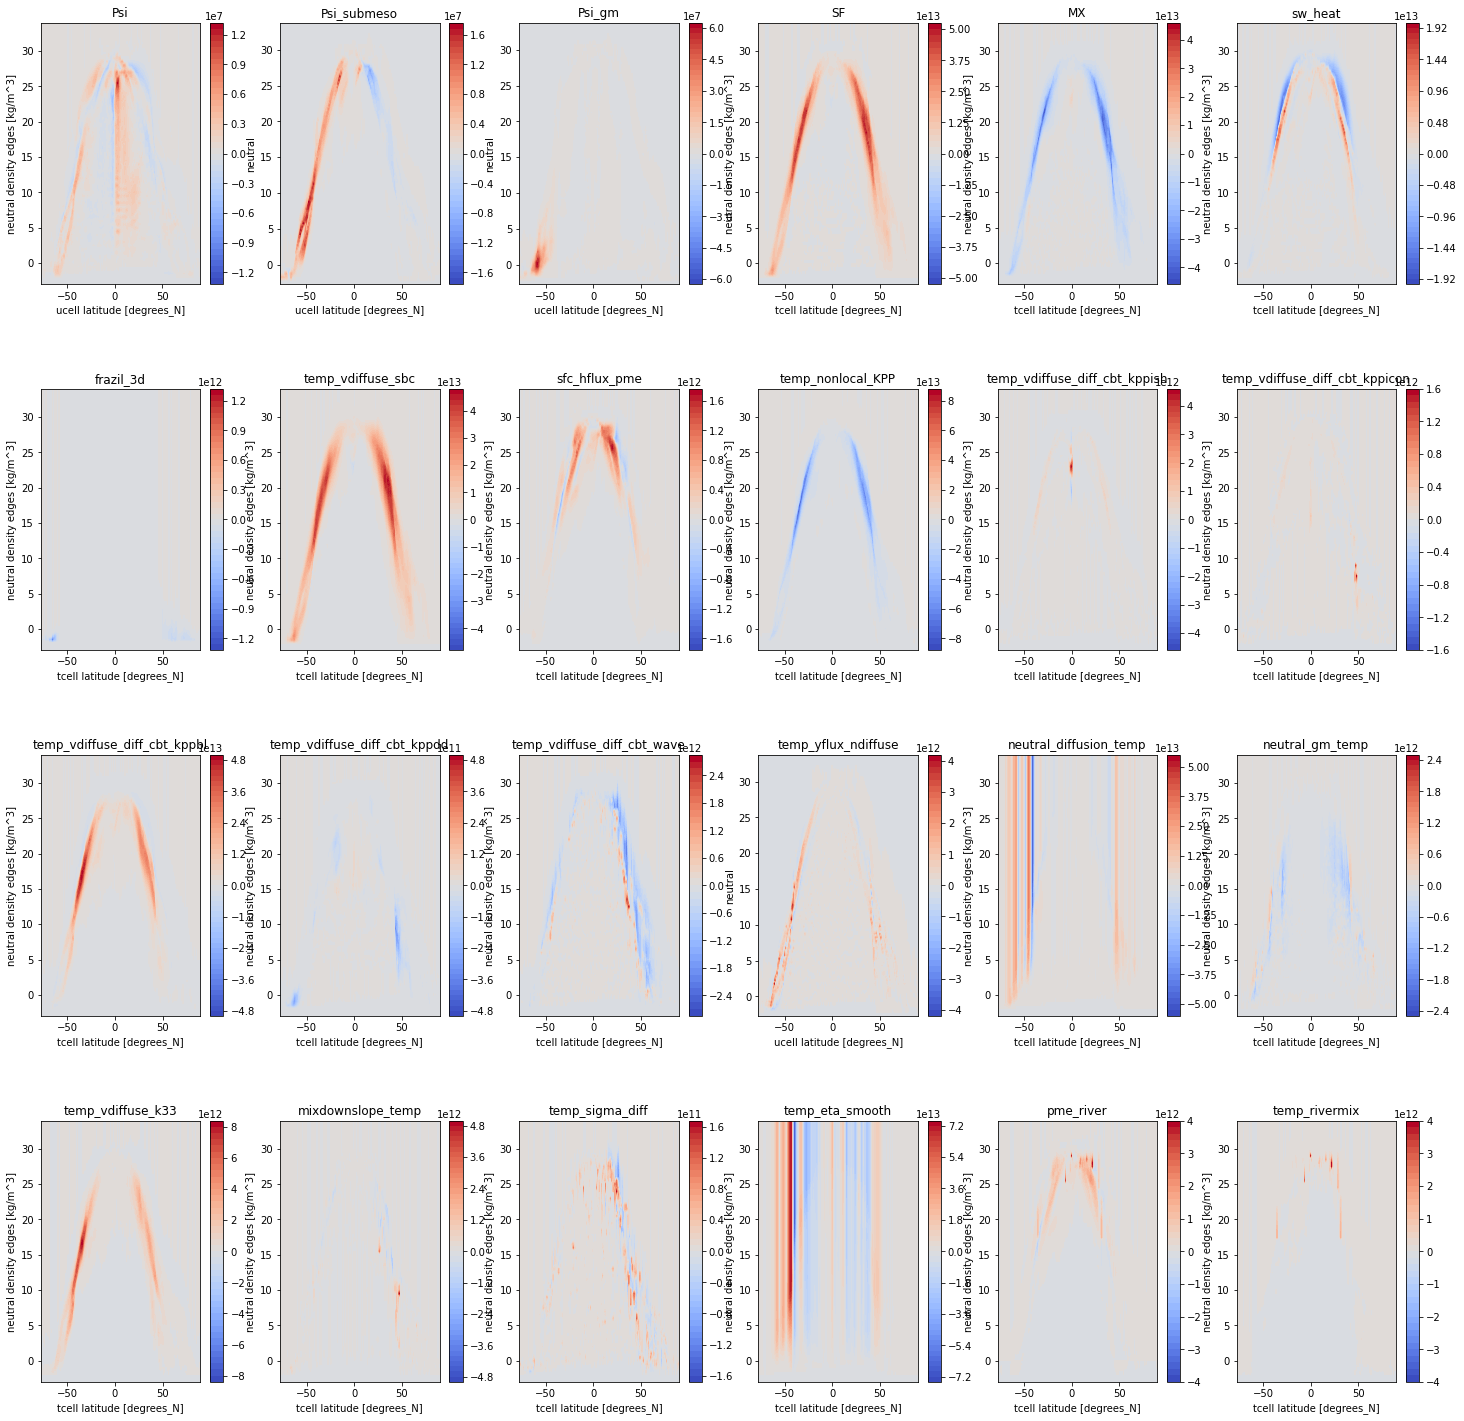

In [78]:
fig = plt.figure(figsize=(25,25),facecolor='w')
cmap = 'coolwarm'
for j in np.arange(24):
    print(j)
    plt.subplot(4,6,j+1)
    field = fields[j]
    plotting = (field.sum('grid_xt_ocean'))
    plotting.load()
    plotting.plot.contourf(cmap=cmap, levels = 51)
    plt.title(fieldnames[j])
fig.subplots_adjust(hspace = 0.4)
plt.show()
